In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pawflim import pawflim

## Helper functions

We define some general helper functions to simulate, compute, and plot phasors.

In [2]:
def semicircle(ax: plt.Axes = None, **kwargs):
    """Plots the monoexponential semicircle."""
    from matplotlib.patches import Arc

    if ax is None:
        ax = plt.gca()

    return ax.add_patch(Arc((0.5, 0), 1, 1, theta2=180.0, **kwargs))


def phasor_plot(r: np.ndarray[complex], *, bins: int = 100, ax: plt.Axes = None):
    """Plots a bidimensional histogram in log-scale for phasors."""
    from matplotlib.colors import LogNorm

    if ax is None:
        ax = plt.gca()

    r = r.ravel()
    return ax.hist2d(r.real, r.imag, bins=bins, norm=LogNorm())


def arrival_times_monoexp(lifetime: float, N_photons: int = 1):
    """Sample arrival times from a single lifetime."""
    return np.random.exponential(lifetime[..., None], size=(*lifetime.shape, N_photons))


def fourier_coefficient(t: np.ndarray, freq: float):
    """Calculates Fourier coefficient from arrival times."""
    w = 2 * np.pi * freq
    return np.exp(1j * w * t).sum(axis=-1)


def normal_lifetime(r: np.ndarray, freq: float):
    """Compute normal lifetime from phasor.

    Projects normally to the single-lifetime semicircle.

    Parameters
    ----------
    r : array-like
        Phasor.
    freq : array-like
        Frequency.

    References
    ----------
    Silberberg, M., & Grecco, H. E. (2017). pawFLIM: reducing bias
    and uncertainty to enable lower photon count in FLIM experiments.
    Methods and applications in fluorescence, 5(2), 024016.
    """
    return np.tan(np.angle(r - 0.5) / 2) / (2 * np.pi * freq)

And a function to plot the data to be simulated here.

In [3]:
def plot(phasor, lifetimes, lifetimes_true):
    """Plot phasor and lifimets."""
    fig = plt.figure(figsize=(10, 2))
    fig_lifetime, fig_phasor = fig.subfigures(ncols=2)

    axes = ImageGrid(
        fig_lifetime, 111, nrows_ncols=(1, 2), axes_pad=0.2, cbar_mode="single"
    )
    norm = plt.Normalize(lifetimes.min(), lifetimes.max())
    axes[0].imshow(lifetimes_true, norm=norm)
    mapp = axes[1].imshow(lifetimes, norm=norm)
    axes.cbar_axes[0].colorbar(mapp, label="Lifetime")
    axes[0].set(title="true values")
    axes[1].set(title="measured values")

    ax = fig_phasor.subplots()
    semicircle(ax=ax)
    phasor_plot(phasor, ax=ax)
    ax.set(aspect="equal", xlim=(0, 1))

## Simulation

We simulate four regions of constant lifetime,
and sample $N=200$ photons for each pixel.

In [4]:
lifetimes_true = np.tile(
    np.repeat([1, 2, 3, 4], 32),
    (128, 1),
)
times = arrival_times_monoexp(lifetimes_true, N_photons=200)

From the arrival times,
we calculate the number of photons (zeroth harmonic)
and first two harmonics for each pixel.

In [5]:
freq = 1 / 25
N = fourier_coefficient(times, freq=0 * freq)
R1 = fourier_coefficient(times, freq=1 * freq)
R2 = fourier_coefficient(times, freq=2 * freq)

and plot the phasor corresponding to the first harmonic:

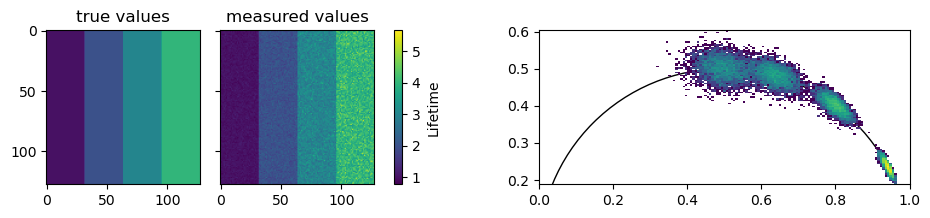

In [6]:
phasor = R1 / N

plot(
    phasor,
    lifetimes=normal_lifetime(phasor, freq),
    lifetimes_true=lifetimes_true,
)

## pawFLIM

To denoise based on the phasor values of the $n$-th harmonic,
`pawflim` requires:
- the number of photons
- the $n$-th harmonic
- the $2n$-th harmonic

We create an array,
where we concatenate these values in the first dimension,
and pass that array to the `pawflim` function.
The `n_sigmas` parameter sets the threshold level
in terms of the equivalent one-dimensional standard deviation.

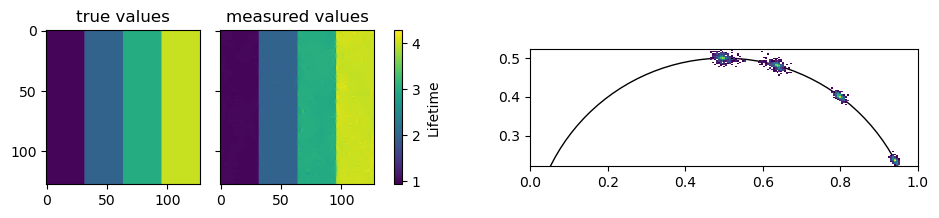

In [7]:
data = np.empty((3, *R1.shape), dtype=complex)
data[0] = N
data[1] = R1
data[2] = R2

data = pawflim(data, n_sigmas=3)  # try different n_sigmas values

phasor = data[1] / data[0]
plot(
    phasor,
    lifetimes=normal_lifetime(phasor, freq),
    lifetimes_true=lifetimes_true,
)